# Description

Learn about the target 

# Prepare data 


In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

In [2]:
df_cust = catalog.load("customers")
d_sex = {1: 'male', 2: 'female', 0: 'other'}
df_cust.sex = df_cust.sex.apply(lambda x: d_sex[x])

df_cust['residentialAddress_clean'] = df_cust.residentialAddress.apply(
    lambda x: re.sub(r'[0-9]+', '', x))
df_cust['postalAddress_clean'] = df_cust.postalAddress.apply(
    lambda x: re.sub(r'[0-9]+', '', x) if x == x else '')
df_cust['same_address'] = (
    df_cust.residentialAddress == df_cust.postalAddress).astype(int)

In [3]:
df_trans = catalog.load("transactions")

df_trans['late'] = df_trans.filter(regex='payment').apply(
    lambda x: x == 1).any(axis=1).astype(int)

df_trans['default'] = df_trans.filter(regex='payment').apply(
    lambda x: x == 2).any(axis=1).astype(int)

df_trans["defualted_payment"] = df_trans.replace({
    'paymentStatus1': {1: 0, 2: 1},
    'paymentStatus2': {1: 0, 2: 2},
    'paymentStatus3': {1: 0, 2: 3},
    'paymentStatus4': {1: 0, 2: 4},
}).filter(regex='payment').replace({0: np.nan}).min(axis=1).fillna(0)

df_trans = df_trans.assign(
    money_lost=lambda x: x.apply(
        lambda y: y['price'] * (5-y['defualted_payment'])/4 if y['defualted_payment'] > 0 else 0, axis=1
    )
)

df_trans["late_payment_first"] = df_trans.replace({
    'paymentStatus1': {1: 1, 2: 0},
    'paymentStatus2': {1: 2, 2: 0},
    'paymentStatus3': {1: 3, 2: 0},
    'paymentStatus4': {1: 4, 2: 0},
}).filter(regex='payment').replace({0: np.nan}).min(axis=1).fillna(0)

# mark transactions from shop 113 as a fraud
df_trans['fraud'] = 0
df_trans.loc[df_trans.shopID == 113, 'fraud'] = 1

# drop transaction marked as a fraud and transaction without customerID
df_trans = df_trans.loc[df_trans.fraud == 0].dropna(
    subset=['customerID']).reset_index(drop=True)

# rank customer transactions
df_trans['rank'] = df_trans.groupby("customerID")["transactionID"].rank(
    "dense", ascending=True)


# treat last customer transaction as current credit application
df_trans['rank_reverse'] = df_trans.groupby("customerID")["transactionID"]. \
    rank("dense", ascending=False)

# split transactions into current transaction and historical
df_trans_newest = df_trans.loc[df_trans.rank_reverse == 1]. \
    reset_index(drop=True)
df_trans_history = df_trans.loc[df_trans.rank_reverse > 1].\
    reset_index(drop=True)

# aggregate transaction history
df_trans_history_aggr = df_trans_history. \
    groupby('customerID'). \
    agg(
        hist_trans_count=('default', 'count'),
        hist_default_sum=('default', 'sum'),
        hist_default_avg=('default', 'mean'),
        hist_late_sum=('late', 'sum'),
        hist_late_avg=('late', 'mean'),
        hist_price_sum=('price', 'sum'),
        hist_price_avg=('price', 'mean')
    ).reset_index(drop=False)

# join historical transaction features created by aggregation all values
df_trans_newest = df_trans_newest.merge(
    df_trans_history_aggr, on='customerID', how='left')

df_trans = df_trans_newest

In [4]:
# join data
df = df_cust.merge(df_trans, on=['customerID'],
                             how='left')
# drop clients without transactions
df = df.dropna(subset=['default'])

# Default rate vs "pseudo time"

It is important to know haow target behave over time.
There is no transaction data available, but since transactions ID are increasing, I can asume that the higher ID is, the older transaction is.       
Based on this assumption I'm creating 'pseudo time' dimension to show target behaves over time.


<AxesSubplot:xlabel='pseudo_date'>

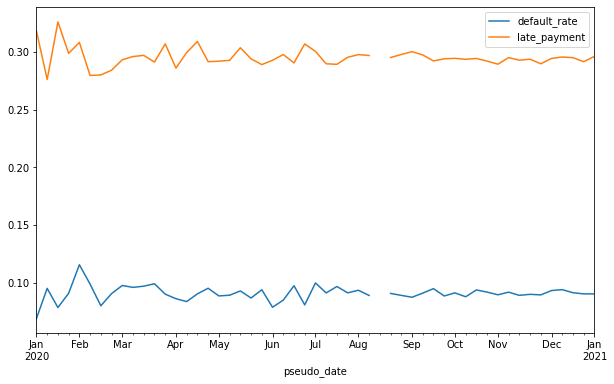

In [5]:
number_of_weeks = 52
fig, ax1 = plt.subplots(figsize=(10,6))

dates = dict([i for i in zip(range(number_of_weeks), pd.date_range(start='2020-01-01', end='2020-12-31',periods=number_of_weeks))])
div = round(df.transactionID.max()/(number_of_weeks-1),0)
df['pseudo_date'] = df.transactionID.apply(lambda x: int(round(x/div,0))).map(lambda x: dates[x])
df.set_index('pseudo_date').resample('W')[['default']].agg(default_rate=('default', 'mean')).plot(ax=ax1)
df.set_index('pseudo_date').resample('W')[['late']].agg(late_payment=('late', 'mean')).plot(ax=ax1)


There is a discontinuity at some point on the graph - it's caused by removing from the data a fraudulent shop or observations without customer id.

# Default rate (traget) vs #clients transactions

<AxesSubplot:>

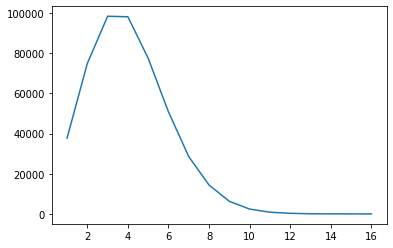

In [6]:
df['rank'].value_counts().sort_index().plot()

For simplification I round down transaction to 10.

In [7]:
df.loc[df['rank']>9,'rank'] = 10

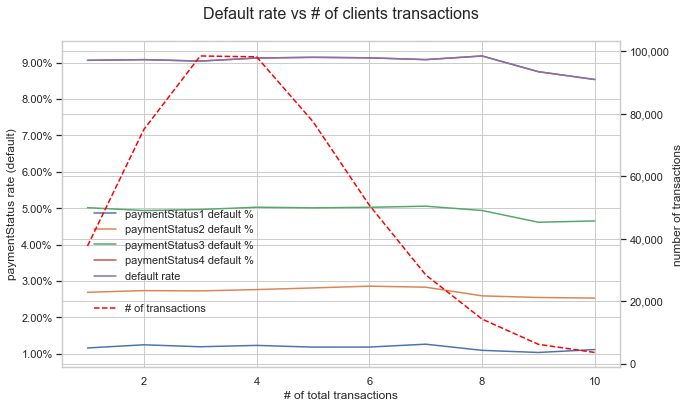

In [8]:
%matplotlib inline
from matplotlib.ticker import FuncFormatter

sns.set(style="whitegrid")

fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()

df.assign(paymentStatus1=lambda x: x['paymentStatus1']==2).groupby('rank')['paymentStatus1'].mean().sort_index().plot(label='paymentStatus1 default %', ax=ax1)
df.assign(paymentStatus2=lambda x: x['paymentStatus2']==2).groupby('rank')['paymentStatus2'].mean().sort_index().plot(label='paymentStatus2 default %', ax=ax1)
df.assign(paymentStatus3=lambda x: x['paymentStatus3']==2).groupby('rank')['paymentStatus3'].mean().sort_index().plot(label='paymentStatus3 default %', ax=ax1)
df.assign(paymentStatus4=lambda x: x['paymentStatus4']==2).groupby('rank')['paymentStatus4'].mean().sort_index().plot(label='paymentStatus4 default %', ax=ax1)
df.groupby('rank')['default'].mean().sort_index().plot(label='default rate', ax=ax1)

df['rank'].value_counts().sort_index().plot(color='red', label='# of transactions' ,ax=ax2)

ax2.lines[0].set_linestyle("--")

ax1.legend(loc = (.05,.25), frameon = False)
ax2.legend(loc = (.05, .15), frameon = False)

ax1.set(xlabel='# of total transactions', ylabel='paymentStatus rate (default)')
ax2.set(ylabel='number of transactions')

plt.title('Default rate vs # of clients transactions', y=1.05, fontsize = 16)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y))) 
ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:,.0f}'.format(y))) 

plt.show()


There is no difference in default rate given the number of transactions that customer has already made.
In real life it's rarely the case.

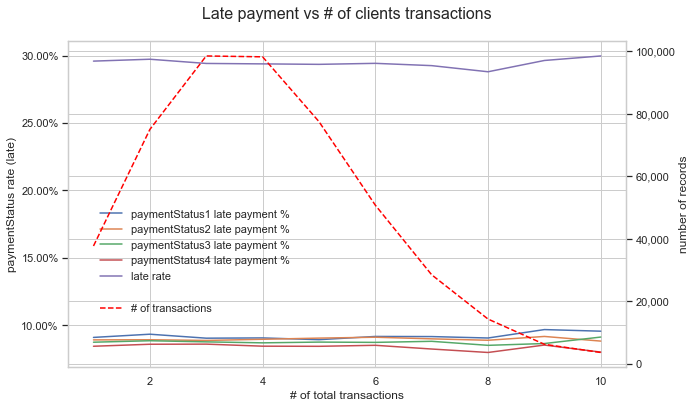

In [9]:
%matplotlib inline
from matplotlib.ticker import FuncFormatter

sns.set(style="whitegrid")

fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()

df.assign(paymentStatus1=lambda x: x['paymentStatus1']==1).groupby('rank')['paymentStatus1'].mean().sort_index().plot(label='paymentStatus1 late payment %', ax=ax1)
df.assign(paymentStatus2=lambda x: x['paymentStatus2']==1).groupby('rank')['paymentStatus2'].mean().sort_index().plot(label='paymentStatus2 late payment %', ax=ax1)
df.assign(paymentStatus3=lambda x: x['paymentStatus3']==1).groupby('rank')['paymentStatus3'].mean().sort_index().plot(label='paymentStatus3 late payment %', ax=ax1)
df.assign(paymentStatus4=lambda x: x['paymentStatus4']==1).groupby('rank')['paymentStatus4'].mean().sort_index().plot(label='paymentStatus4 late payment %', ax=ax1)
df.groupby('rank')['late'].mean().sort_index().plot(label='late rate', ax=ax1)

df['rank'].value_counts().sort_index().plot(color='red', label='# of transactions' ,ax=ax2)

ax2.lines[0].set_linestyle("--")

ax1.legend(loc = (.05,.25), frameon = False)
ax2.legend(loc = (.05, .15), frameon = False)

ax1.set(xlabel='# of total transactions', ylabel='paymentStatus rate (late)')
ax2.set(ylabel='number of records')

plt.title('Late payment vs # of clients transactions', y=1.05, fontsize = 16)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y))) 
ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:,.0f}'.format(y))) 

plt.show()


There is no difference in late payments given the number of transactions that customer has already made.     
